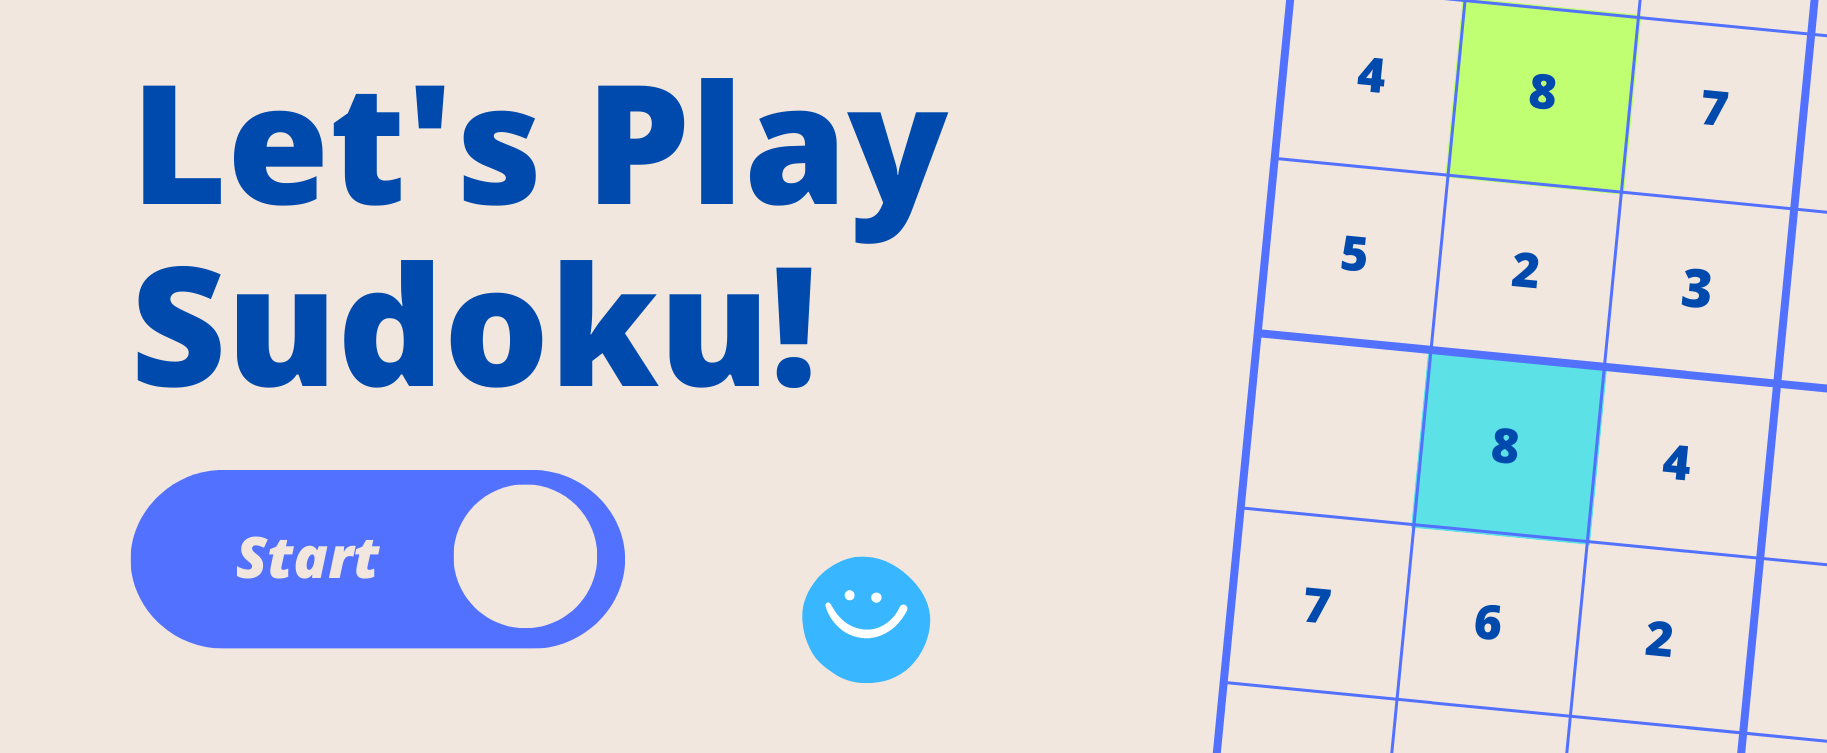
# Introduction to Image Processing Final Project: Sudoku Solver

Welcome to the fascinating world of Image Processing, where we'll be using advanced algorithms to interpret and manipulate digital images. For our final project, we'll be venturing into an exciting and practical application of this technology: a Sudoku Solver. Our end goal is to create a program that not only accepts images of Sudoku puzzles as input but also successfully extracts, interprets, and solves the puzzles embedded within.

## The Magic of Sudoku
Sudoku, a popular number-placement puzzle, traces its roots back to the late 19th century and has captivated minds globally with its simple yet challenging structure. A standard Sudoku puzzle consists of a 9x9 grid, divided into nine 3x3 blocks. The objective is to fill the grid with digits from 1 to 9 in such a way that each column, each row, and each of the nine blocks contains all the digits only once. Solving a Sudoku puzzle demands focus, logic, and patience, making it not just a fun pastime, but also a great mental exercise.

# Preprocessing the Image
The first step is to load the input image and convert it to grayscale. If the image has multiple channels, we extract the first channel assuming it represents the grayscale intensity. We then convert the grayscale image to RGB for visualization purposes.

In [1]:
import numpy as np
from skimage.io import imread, imshow, imsave
from skimage.color import gray2rgb
from skimage import img_as_ubyte, img_as_float
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Flatten, 
                                     Activation, MaxPooling2D, Conv2D)
from tensorflow.keras import backend as K
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

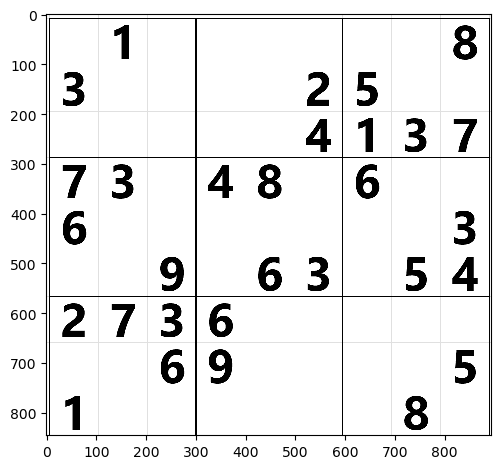

In [2]:
# Load the image
image = imread('sudoku2.png')

# Convert the image to grayscale if it has multiple channels
if image.ndim > 2:
    image = image[:, :, 0]  # Take only the first channel (assuming RGB or RGBA)

# Convert the grayscale image to RGB
img = gray2rgb(image)

# Display the image
imshow(img);

# Perspective Transformation
To extract the Sudoku grid from the image, we define the coordinates of the four corners of the grid. These coordinates are used to estimate a projective transformation that rectifies the grid. The transformed image is displayed to ensure the grid appears as a rectangle. The homographic transformations are performed to square the image up and align it to an image 'layer' that is divisible by 9. Here, since our image has a dimension of about 850 x 900 pixels, mapping it to a 720 x 720 canvas seems practical.

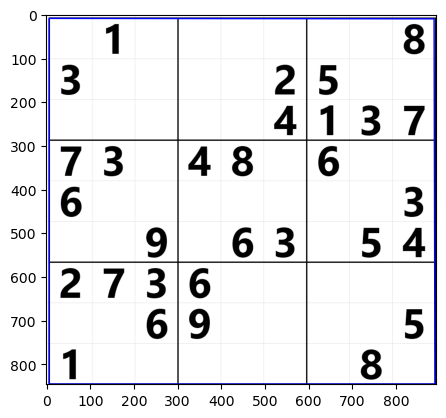

In [54]:
x1 = 6
y1 = 8
x2 = 887
y2 = 9
x3 = 6
y3 = 845
x4 = 889
y4 = 845

source = np.array([x1, y1,
                x2, y2,
                x3, y3,
                x4, y4,
]).reshape((4, 2))

import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

poly_coords = [(x1, y1), (x3, y3), (x4, y4), (x2, y2)]

fig, ax = plt.subplots()
ax.imshow(img)
ax.add_patch(
    plt.Polygon(poly_coords, edgecolor='b', facecolor='none')
);

In [55]:
destination = np.array([0, 0,
                        720, 0,
                        0, 720,
                        720, 720,
]).reshape((4, 2))

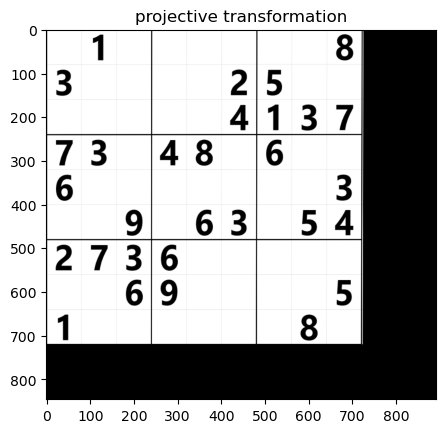

In [57]:
from skimage import transform
tform = transform.estimate_transform('projective', source, destination)

tf_img = transform.warp(img, tform.inverse)
fig, ax = plt.subplots()
ax.imshow(tf_img)
_ = ax.set_title('projective transformation')

After mapping the image to the destination 'layer' of 720 x 720 pixels using homographic transformation, we can trim the image as follows:

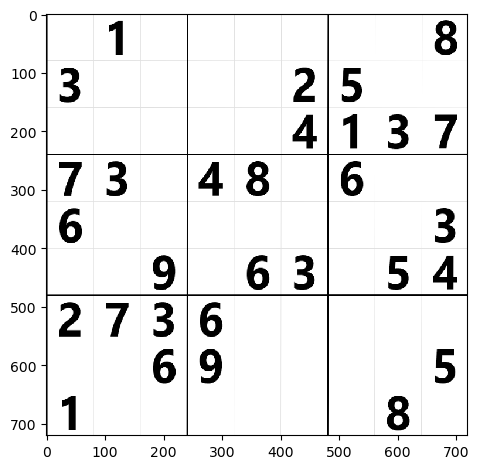

In [58]:
tf_image = tf_img[0:720, 0:720]
imshow(tf_image);

Since the MNIST dataset that we intend to use for the ML model has white text on black background, it is a good idea to invert the resulting sudoku image:

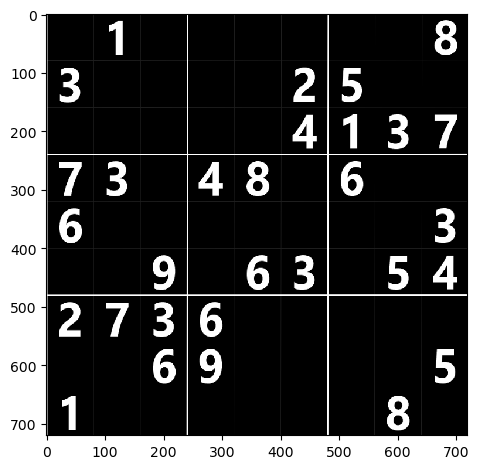

In [62]:
inverted_image = 1 - tf_image
imshow(inverted_image);

# Cell Extraction
Next, we split the transformed image into individual cells corresponding to each number in the Sudoku puzzle. We divide the image into rows and columns, extracting each cell as a separate image. The resulting cells are stored in a list for further processing. The function below is inspired by the Analytics Vidhaya article listed in the reference section.

In [63]:
def split_cells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

In [64]:
sudoku_cell = split_cells(inverted_image)

In [65]:
len(sudoku_cell)

81

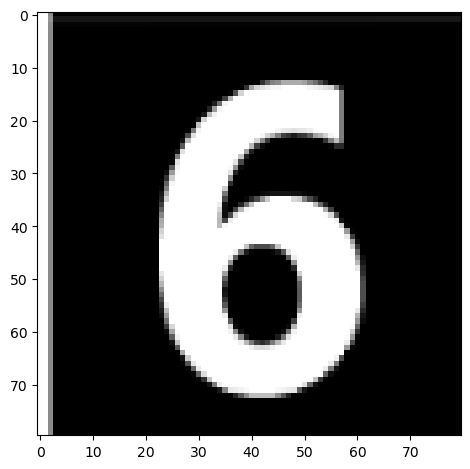

In [70]:
imshow(sudoku_cell[36]);

We are now left with 81 tiles or 'cells' and are almost ready to proceed with the training session for the ML model. However, before we do that, it is a good idea to slightly crop these individual tiles to exclude the white boundary lines that are sometimes visible in our initial tiles. Shaving 4 pixels on each side looks reasonable for our application...

In [71]:
def CropCell(cells):
    cells_cropped = []
    for image in cells:
        # im = np.array(image)
        im = image[4:76, 4:76]
        #im = Image.fromarray(im)
        cells_cropped.append(im)
    return cells_cropped

In [72]:
sudoku_tiles = CropCell(sudoku_cell)

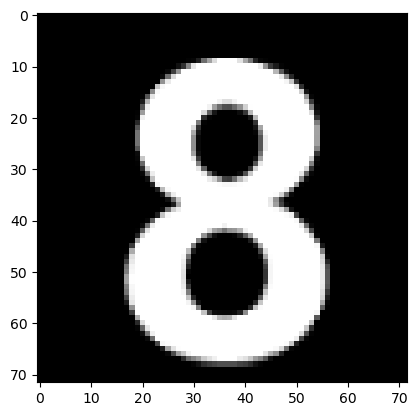

In [74]:
plt.figure()
plt.imshow(sudoku_tiles[79])
plt.show()

In [82]:
from skimage.color import rgb2gray
rgb2gray(sudoku_tiles[79]).shape

(72, 72)

Now we are left with 81 square tiles that are 72 pixels wide (and tall). We are now ready to train our ML Model. 

# Number Recognition
We utilize a pre-trained convolutional neural network (CNN) model, trained on the MNIST dataset, for number recognition. The model is loaded and compiled using the Keras library. The training data is prepared by reshaping and normalizing the MNIST dataset. The model is trained on this data to classify the digits from 0 to 9.

In [75]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [76]:
# Reshape the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [77]:
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout


# Verify the shape of your targets
print(y_train.shape)  # Should be (number_of_samples, 10)

# Build the model
model = Sequential()
model.add(Conv2D(32, (5, 5), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  # Note the 10 units here

# initialize the optimizer
opt = Adam(learning_rate=1e-3)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, y_test))

# Save the model
model.save('sudoku_numbers_predict.h5')

# Evaluate the model
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the classification report
print(classification_report(y_true, y_pred))

(60000, 10)
Epoch 1/10
469/469 [==============================] - 19s 39ms/step - loss: 0.6624 - accuracy: 0.7795 - val_loss: 0.0777 - val_accuracy: 0.9760
Epoch 2/10
469/469 [==============================] - 17s 37ms/step - loss: 0.2301 - accuracy: 0.9331 - val_loss: 0.0528 - val_accuracy: 0.9854
Epoch 3/10
469/469 [==============================] - 18s 39ms/step - loss: 0.1730 - accuracy: 0.9496 - val_loss: 0.0507 - val_accuracy: 0.9850
Epoch 4/10
469/469 [==============================] - 18s 39ms/step - loss: 0.1462 - accuracy: 0.9582 - val_loss: 0.0372 - val_accuracy: 0.9885
Epoch 5/10
469/469 [==============================] - 18s 38ms/step - loss: 0.1226 - accuracy: 0.9646 - val_loss: 0.0331 - val_accuracy: 0.9901
Epoch 6/10
469/469 [==============================] - 18s 38ms/step - loss: 0.1126 - accuracy: 0.9671 - val_loss: 0.0334 - val_accuracy: 0.9903
Epoch 7/10
469/469 [==============================] - 19s 41ms/step - loss: 0.1037 - accuracy: 0.9699 - val_loss: 0.0317 - v

# Classifying Sudoku Numbers

Using the code below, we feed each sudoku tile to our ML model. Since the MNIST dataset is composed of handwritten images that are 28 x 28 pixels in size, each tile gets resized to the same dimensions before it gets gobbled up by the model. The final output of the code below is a two-column dataframe containing the ML's predictions on the first column and the sum of the pixel intensity values on the second column. The sum of the pixel intensity values provide additional context that we can leverage later.

In [197]:
import cv2
from skimage.color import rgb2gray
import pandas as pd


extracted_numbers = []
sum_ = []
for n in range(81): 
    i = cv2.resize(rgb2gray(sudoku_tiles[n]), (28, 28))
    i = i.reshape((1, 28, 28, 1))

    extracted_numbers.append(np.argmax(model.predict(i)))
    sum_.append(sudoku_tiles[n].sum())

df = pd.DataFrame(
    {
        'numbers': extracted_numbers,
        'sums_of_values': sum_
    }
)

1/1 [==============================] - 0s 35ms/step


In [192]:
df

,numbers,sums_of_values
0,8,0.000000
1,7,2470.070441
2,8,0.000000
3,8,0.000000
4,8,0.000000
...,...,...
76,8,0.000000
77,8,0.000000
78,8,0.000000
79,8,4333.481478


# Post-processing
Upon testing, we found that our model, trained on MNIST data, finds it difficult to tell 1's and 7's apart, possibly due to its unfamiliarity with squiggly line on top of the number 1 (also called the virgulilla mark), having trained on handwritten digits. For blank cells, it defaults to returning 8's instead of 0's. These issues are easy to fix with a couple of lines of code:

In [199]:
df.loc[df['sums_of_values'] < 5, 'numbers'] = 0
df.loc[(df['numbers'] == 7) & (df['sums_of_values'] < 2550), 'numbers'] = 1
df.loc[(df['numbers'] == 1) & (df['sums_of_values'] >= 2550), 'numbers'] = 7
df

,numbers,sums_of_values
0,0,0.000000
1,1,2470.070441
2,0,0.000000
3,0,0.000000
4,0,0.000000
...,...,...
76,0,0.000000
77,0,0.000000
78,0,0.000000
79,8,4333.481478


In [179]:
def transform_to_array(numbers):
    if len(numbers) != 81:
        print("Error: The list should contain exactly 81 numbers.")
        return None
    
    array = []
    for i in range(9):
        row = numbers[i*9:(i+1)*9]
        array.append(row)
    
    return array

In [200]:
transform_to_array(df['numbers'].tolist())

[[0, 1, 0, 0, 0, 0, 0, 0, 8],
 [3, 0, 0, 0, 0, 2, 5, 0, 0],
 [0, 0, 0, 0, 0, 4, 1, 3, 7],
 [7, 3, 0, 4, 8, 0, 6, 0, 0],
 [6, 0, 0, 0, 0, 0, 0, 0, 3],
 [0, 0, 9, 0, 6, 3, 0, 5, 4],
 [2, 7, 3, 6, 0, 0, 0, 0, 0],
 [0, 0, 6, 9, 0, 0, 0, 0, 5],
 [1, 0, 0, 0, 0, 0, 0, 8, 0]]

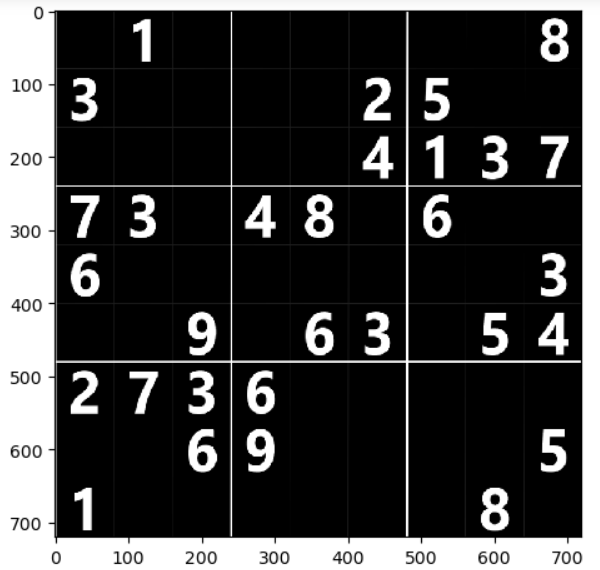

Using the code above, we assign a 0 digit to the blank cells (they have 0 intensity values). We can also use the sums to differentiate between a 1 or a 7.  

After applying the corrections, the function block `transform_to_array` is used to transform the column of predicted digits into a 9 x 9 array that our Sudoku Engine can understand.

# Sudoku Solver Engine
Finally, we feed the extracted Sudoku grid into a solver engine based on backtracking algorithm. The solver recursively attempts to fill in the empty cells of the Sudoku grid by trying different numbers and checking for validity. Once the solver successfully fills in all the cells, the solved Sudoku grid is displayed.

Code for the solver engine is based on https://www.makeuseof.com/python-create-sudoku-solver/

In [217]:
board = transform_to_array(df['numbers'].tolist())
board

[[0, 1, 0, 0, 0, 0, 0, 0, 8],
 [3, 0, 0, 0, 0, 2, 5, 0, 0],
 [0, 0, 0, 0, 0, 4, 1, 3, 7],
 [7, 3, 0, 4, 8, 0, 6, 0, 0],
 [6, 0, 0, 0, 0, 0, 0, 0, 3],
 [0, 0, 9, 0, 6, 3, 0, 5, 4],
 [2, 7, 3, 6, 0, 0, 0, 0, 0],
 [0, 0, 6, 9, 0, 0, 0, 0, 5],
 [1, 0, 0, 0, 0, 0, 0, 8, 0]]

In [218]:
def print_board(board):
    for row in range(9):
        if row % 3 == 0 and row != 0:
            print("- - - - - - - - - - - -")
        for col in range(9):
            if col % 3 == 0 and col != 0:
                print(" | ", end="")
            if col == 8:
                print(board[row][col])
            else:
                print(str(board[row][col]) + " ", end="")


In [219]:
def find_empty(board):
    for row in range(9):
        for col in range(9):
            if board[row][col] == 0:
                return (row, col)
    return None

In [220]:
def is_valid(board, num, pos):
    # Check row
    for col in range(9):
        if board[pos[0]][col] == num and pos[1] != col:
            return False

    # Check column
    for row in range(9):
        if board[row][pos[1]] == num and pos[0] != row:
            return False

    # Check 3x3 box
    box_row = pos[0] // 3
    box_col = pos[1] // 3
    for row in range(box_row*3, box_row*3 + 3):
        for col in range(box_col*3, box_col*3 + 3):
            if board[row][col] == num and (row, col) != pos:
                return False

    return True

In [221]:
def solve(board):
    find = find_empty(board)
    if not find:
        return True
    else:
        row, col = find

    for num in range(1, 10):
        if is_valid(board, num, (row, col)):
            board[row][col] = num

            if solve(board):
                return True

            board[row][col] = 0

    return False  

In [222]:
print('Unsolved board: ')
print_board(board)
solve(board)
print('')
print('Solution:')
print_board(board)

Unsolved board: 
0 1 0  | 0 0 0  | 0 0 8
3 0 0  | 0 0 2  | 5 0 0
0 0 0  | 0 0 4  | 1 3 7
- - - - - - - - - - - -
7 3 0  | 4 8 0  | 6 0 0
6 0 0  | 0 0 0  | 0 0 3
0 0 9  | 0 6 3  | 0 5 4
- - - - - - - - - - - -
2 7 3  | 6 0 0  | 0 0 0
0 0 6  | 9 0 0  | 0 0 5
1 0 0  | 0 0 0  | 0 8 0

Solution:
9 1 7  | 5 3 6  | 4 2 8
3 4 8  | 7 1 2  | 5 6 9
5 6 2  | 8 9 4  | 1 3 7
- - - - - - - - - - - -
7 3 1  | 4 8 5  | 6 9 2
6 5 4  | 2 7 9  | 8 1 3
8 2 9  | 1 6 3  | 7 5 4
- - - - - - - - - - - -
2 7 3  | 6 5 8  | 9 4 1
4 8 6  | 9 2 1  | 3 7 5
1 9 5  | 3 4 7  | 2 8 6


# Conclusion
Our journey into the world of image processing, AI, and puzzles comes to a successful conclusion as we realize our project's main goal: building a functional and efficient Sudoku Solver. Using image processing techniques, we extracted the Sudoku grid from an image, recognized the numbers in the puzzle, and fed this data into a Sudoku solver to find the solution.

Our tool demonstrated its ability to overcome a variety of challenges. It accurately extracted the grid from a variety of images, recognized and classified the digits in each cell of the puzzle correctly, and ultimately solved the Sudoku puzzles effectively.

Although we encountered challenges along the way, especially in the digit recognition phase, we implemented corrections to ensure accuracy. For instance, we improved the differentiation between 1's and 7's and accounted for blank cells, which were initially incorrectly recognized as 8's.

# Recommendations and Future Work
While the Sudoku Solver has shown impressive results, there is always room for improvement and further exploration. Here are some suggestions for future work:

1. **Digit Recognition Improvements**: To improve the recognition of certain digits, especially 1's and 7's, training the model on a broader dataset, including printed digits or even customized handwriting, could be beneficial.

2. **Handling of Noisy Images**: The solver could be made more robust by improving its ability to handle noisy images, including images with other elements besides the Sudoku puzzle.

3. **Grid Extraction Improvements**: The process of identifying and extracting the grid from an image could be made automatic rather than relying on manual input of the grid coordinates. Advanced techniques like Hough Transform can be used to detect lines and corners.

4. **User Interface Development**: A user-friendly interface could be developed to allow users to easily upload images of Sudoku puzzles and get the solutions.

5. **Real-time Application**: The Sudoku Solver could be expanded into a real-time application using a webcam or smartphone camera as the source of Sudoku puzzle images.

Our journey with the Sudoku Solver has been exciting and informative. This project demonstrated the power of image processing and AI in tackling complex problems. It has also opened doors to many other potential applications, from solving other types of puzzles to reading documents and more. The potential applications are only limited by our imagination.

As technology continues to evolve, projects like this offer a glimpse into a future where AI can seamlessly interact with and interpret the visual world, providing solutions and assistance in ways we are only beginning to explore.

# References

Karmakar, J. (2021, May 10). Solving Sudoku from Image using Deep Learning with Python Code. Analytics Vidhya. Retrieved from https://www.analyticsvidhya.com/blog/2021/05/solving-sudoku-from-image-using-deep-learning-with-python-code/

Bakshi, A. (n.d.). How to Create a Sudoku Solver in Python. MakeUseOf. Retrieved from https://www.makeuseof.com/python-create-sudoku-solver/